In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
# from sklearn.decomposition import FastICA
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.model_selection import cross_val_score
# from itertools import combinations
# from sklearn.preprocessing import normalize
# from sklearn.utils import shuffle
import pickle

from multiprocessing import Pool
plt.style.use('seaborn-whitegrid')

# GroudTruth

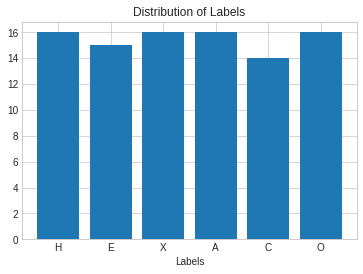

In [2]:
gt = load_groudtruth('./HEXACO.csv')
fig, ax = plt.subplots()
ax.bar(['H','E','X','A','C','O'],[ sum(gt['lh']), sum(gt['le']), sum(gt['lx']), sum(gt['la']), sum(gt['lc']), sum(gt['lo'])  ])
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

# Load DATA

In [3]:
# clear_cache()
try:
    # Load from cache
    EEG_audio = load('EEG_audio')
    EEG_image = load('EEG_image')
    print('Load data from cache')
    if( set(EEG_audio.keys()) != set(EEG_image.keys()) ):
        extra = None
        if(len(EEG_audio.keys()) > len(EEG_image.keys())):
            extra = set(EEG_audio.keys()).difference( set(EEG_image.keys()) )
        else:
            extra = set(EEG_image.keys()).difference( set(EEG_audio.keys()) )
        raise ValueError(f"In equal keys. audio has {len(EEG_audio.keys())} and image has {len(EEG_image.keys())}. The extra key is {extra}")

except FileNotFoundError as e:
    EEG_audio, EEG_image = load_data(path='./data',exclude_list=[11,36])
    # Save to cache
    save(EEG_audio, 'EEG_audio')
    save(EEG_image, 'EEG_image')


Load data from cache


# Generic Head Model

In [4]:
def get_head_model():
    import os.path as op
    import numpy as np

    import mne
    from mne.datasets import eegbci
    from mne.datasets import fetch_fsaverage

    # Download fsaverage files
    fs_dir = fetch_fsaverage(verbose=True)
    subjects_dir = op.dirname(fs_dir)

    # The files live in:
    subject = 'fsaverage'
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
    bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
    return trans, src, bem

def get_forward(raw):
    trans, src, bem = get_head_model()
    fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                bem=bem, eeg=True, mindist=5.0, n_jobs=1)
    return fwd

In [ ]:
# mne.set_config('SUBJECTS_DIR','/home/akrarads/mne_data/MNE-fsaverage-data')
# mne.get_config()

# Processing

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 8251 samples (33.004 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.05 Hz
- Upper transition bandwidth: 0.05 Hz
- Filter length: 16501 samples (66.004 sec)



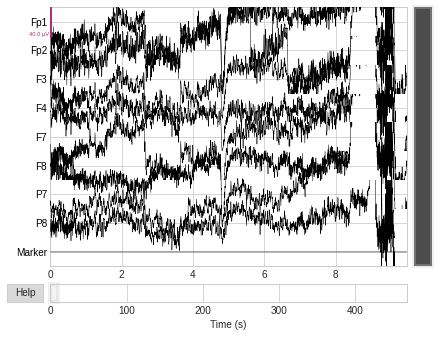

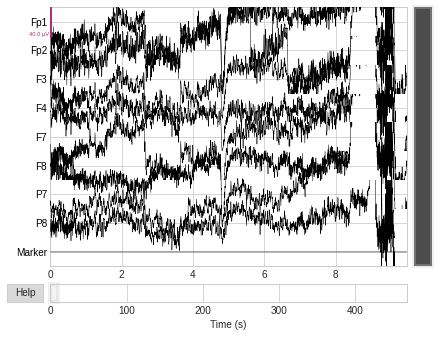

In [15]:
raw = dataframe_to_raw(EEG_image[33], sfreq=250)
#### Preprocess
# High-pass at 0.1 Hz with  FIR filter; zero phase; Hamming Window; Auto select length and Bandwidth
raw.filter(l_freq=0.1,h_freq=None,method='fir',phase='zero',fir_window='hamming', verbose=True) # Slow drift
# Notch Filter at 50,100,150,200 Hz with FIR filter; zero phase; Hamming Window, Bandwidth = 0.1; auto length selection
raw.notch_filter(freqs=[50,100],method='fir', phase='zero', fir_window='hamming',trans_bandwidth=0.1, filter_length='auto', verbose=True) # Line power
raw.plot()

In [11]:
fwd = get_forward(raw)

0 files missing from root.txt in /home/akrarads/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/akrarads/mne_data/MNE-fsaverage-data/fsaverage
Source space          : /home/akrarads/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /home/akrarads/venv/hci/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /home/akrarads/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /home/akrarads/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.00000